# Question: How is revenue distributed with respect to runtime?
We would like to know how median inflation adjusted revenue is distributed with respect to runtime.

## Load the data
Below we import the necessary libraries and connect to the database.

In [1]:
import pandas as pd
import numpy as np
import cpi
import seaborn as sns
import matplotlib.pyplot as plt
from moviesdb import moviesdb as mdb

### Update the consumer price index library

In [2]:
#cpi.update()

### Connect to the database

In [2]:
db = mdb.MoviesDb()

In [3]:
for table in db.list_tables():
    print(f'\n=== {table} ===\n')
    for column in db.list_column_names(table):
        print(column)


=== titles ===

tconst
primary_title
start_year

=== runtimes ===

tconst
runtime_minutes

=== genres ===

tconst
Action
Adult
Adventure
Animation
Biography
Comedy
Crime
Documentary
Drama
Family
Fantasy
Game_Show
History
Horror
Music
Musical
Mystery
News
Reality_TV
Romance
Sci_Fi
Short
Sport
Talk_Show
Thriller
War
Western

=== ratings ===

tconst
averagerating
numvotes

=== budgets ===

id
primary_title
start_year
release_date
production_budget
domestic_gross
worldwide_gross

=== names ===

nconst
primary_name

=== principals ===

tconst
ordering
nconst
category


In [5]:
query = """
SELECT t.start_year, ru.runtime_minutes, b.production_budget, b.domestic_gross, b.worldwide_gross
FROM budgets AS b
JOIN titles AS t
USING('primary_title', 'start_year')
JOIN runtimes as ru
USING('tconst')
"""
df = db.load_query_as_df(query)

## Question specific data cleaning
To ensure that consumer price index data is available, we restrict our analysis to movies released before 2019.

In [6]:
df = df.query('start_year <= 2018')

## Computations
Below we inflate production budgets to 2018 United States Dollars.

In [10]:
def inflate_to_2018(x):
    inflated = cpi.inflate(value=x[1], year_or_month=int(x[0]), to=2018)
    return inflated

In [30]:
df_adjusted = pd.DataFrame()
df_adjusted['runtime_minutes'] = df['runtime_minutes']
df_adjusted['adjusted_budget'] = df[['start_year','production_budget']].apply(inflate_to_2018, axis=1)
df_adjusted['adjusted_worldwide_gross'] = df[['start_year','worldwide_gross']].apply(inflate_to_2018, axis=1)
df_adjusted['adjusted_domestic_gross'] = df[['start_year','domestic_gross']].apply(inflate_to_2018, axis=1)
df_adjusted['worldwide_revenue'] = df_adjusted['adjusted_worldwide_gross'] - df_adjusted['adjusted_budget']
df_adjusted['domestic_revenue']  = df_adjusted['adjusted_domestic_gross'] - df_adjusted['adjusted_budget']

Below we aggregate the median values of our financial variables with respect to runtime.

In [31]:
df_agg = df_adjusted.groupby(by='runtime_minutes').agg('median').reset_index()

Below we compute rolling averages of our financial variables with a window of ten minutes. This serves to smooth the minute-by-minute variation in the data. 

In [15]:
df_smoothed = df_agg.rolling(on= 'runtime_minutes', window=10).sum()

## Data visualization
Below we produce a regression plot of the median inflation adjusted production budget in 2018 USD. 

<Figure size 576x396 with 0 Axes>

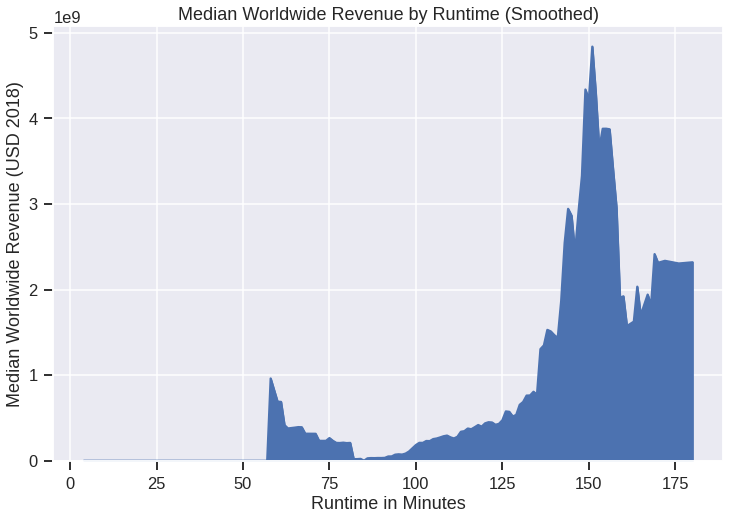

In [46]:
plt.figure()
plt.style.use('seaborn')
sns.set_context('talk')
df_smoothed.plot.area(x='runtime_minutes', 
                      y='worldwide_revenue', 
                      figsize=(12,8),
                      xlabel = 'Runtime in Minutes', 
                      ylabel = 'Median Worldwide Revenue (USD 2018)', 
                      title = 'Median Worldwide Revenue by Runtime (Smoothed)',
                      legend = None,
                
                     );
plt.savefig('../images/revenue_by_runtime.png', bbox_inches='tight');

# Conclusion
We see that inflation adjusted median revenue peaks near 151 minutes. 

In [47]:
argmax = df_smoothed['runtime_minutes'][df_smoothed['worldwide_revenue'].idxmax()]

In [48]:
print(f'Worldwide revenue is maximized at a runtime of around {argmax} minutes.')

Worldwide revenue is maximized at a runtime of around 151 minutes.
